<a href="https://colab.research.google.com/github/kvin-alxndr/face-recognition/blob/main/face-recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PCA and DL ConvNet Face Recognition


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Configuración

In [ ]:
import gc

gc.collect()

0

In [ ]:
# Instalación de dependencias

!pip install tensorflow opencv-python matplotlib

In [ ]:
!pip list

In [ ]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2 as cv
from sklearn.model_selection import train_test_split

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[]

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

# Eigenfaces

## Carga y preprocesamiento de los datos


   Nombre                                             Imagen  Etiqueta
0  Andres  [213, 213, 213, 213, 213, 213, 212, 212, 212, ...         0
1  Andres  [212, 212, 213, 214, 214, 215, 214, 213, 214, ...         0
2  Andres  [205, 205, 206, 207, 208, 208, 209, 208, 209, ...         0
3  Andres  [213, 213, 213, 213, 213, 214, 214, 215, 214, ...         0
4  Andres  [211, 212, 212, 212, 211, 212, 212, 213, 213, ...         0


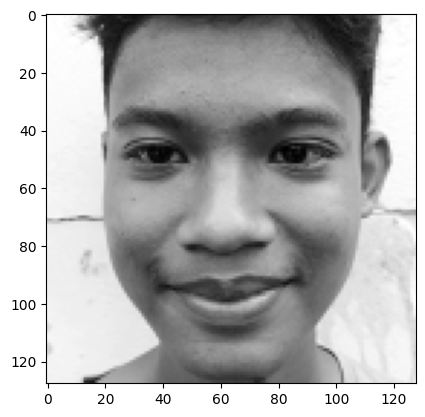

In [ ]:
def crear_etiquetas(num_personas, num_imagenes):
    vector_etiquetas = []
    if num_personas <= 0:
        raise ValueError("El número de personas debe ser mayor que cero.")

    for persona in range(num_personas):
        etiquetas_persona = [persona] * num_imagenes
        vector_etiquetas.extend(etiquetas_persona)

    return vector_etiquetas

def cargar_imagenes_carpeta(carpeta):
    imagenes = []
    nombres = []
    etiquetas = []

    for nombre in os.listdir(carpeta):
        nombre_path = os.path.join(carpeta, nombre)
        if os.path.isdir(nombre_path):
            imagenes_persona = []
            for imagen_nombre in os.listdir(nombre_path):
                imagen_path = os.path.join(nombre_path, imagen_nombre)
                if os.path.isfile(imagen_path):
                    # Cargar la imagen con OpenCV y convertirla a escala de grises
                    imagen = cv.imread(imagen_path, cv.IMREAD_GRAYSCALE)
                    imagen = cv.resize(imagen, (128, 128))
                    # Añadir la imagen a la lista de imágenes de la persona
                    imagenes_persona.append(imagen.flatten())

            # Añadir las imágenes y el nombre a las listas
            imagenes.extend(imagenes_persona)
            nombres.extend([nombre] * len(imagenes_persona))
            etiquetas.extend([nombres.index(nombre)] * len(imagenes_persona))

    # Crear etiquetas utilizando la función crear_etiquetas
    etiquetas = crear_etiquetas(len(set(nombres)), len(imagenes) // len(set(nombres)))

    return pd.DataFrame({'Nombre': nombres, 'Imagen': imagenes, 'Etiqueta': etiquetas})
# Carpeta que contiene carpetas con el nombre de cada persona
carpeta_principal = 'Dataset'

# Crear DataFrame
df = cargar_imagenes_carpeta(carpeta_principal)
df_cnn = df

print(df.head())

# Mostrar la primera imagen del DataFrame
imagen_primera = df['Imagen'][8]

# Mostrar la imagen con Matplotlib
plt.imshow(imagen_primera.reshape(128,128), cmap='gray')  # cmap='gray' asegura que la imagen se muestre en escala de grises
plt.show()



In [ ]:
# Reformateo del dataframe
# Convertir la columna "Imagen" en nuevas columnas
df_imagenes = df['Imagen'].apply(pd.Series)

# Concatenar las nuevas columnas con el DataFrame original
df = pd.concat([df, df_imagenes], axis=1)

# Eliminar la columna original "Imagen"
df = df.drop('Imagen', axis=1)
df = df.drop(['Nombre'],axis=1)


In [ ]:
print(df.head())

   Etiqueta    0    1    2    3    4    5    6    7    8  ...  16374  16375  \
0         0  213  213  213  213  213  213  212  212  212  ...    145    144   
1         0  212  212  213  214  214  215  214  213  214  ...    134    133   
2         0  205  205  206  207  208  208  209  208  209  ...      6      6   
3         0  213  213  213  213  213  214  214  215  214  ...    131    139   
4         0  211  212  212  212  211  212  212  213  213  ...    149    147   

   16376  16377  16378  16379  16380  16381  16382  16383  
0    144    141    132    131    128    126    125    132  
1    126    121    117    118    118    116    116    121  
2      8     10     56     60     55     57     59     23  
3    146    150    141    140    137    134    132    145  
4    148    144    131    132    140    143    140    150  

[5 rows x 16385 columns]


## División del data set

In [ ]:
## Dividir los datos en conjuntos de entrenamiento y prueba
etiquetas = df["Etiqueta"]
pixels = df.drop(["Etiqueta"],axis=1)

x_train, x_test, y_train, y_test = train_test_split(pixels, etiquetas,test_size=0.4, random_state=42)

## Algorítmo (funciones)

In [ ]:
def originales(pixels):
	#Imprime las imagenes originales
	fig, axes = plt.subplots(7, 7, figsize=(11, 7),
	                         subplot_kw={'xticks':[], 'yticks':[]})
	for i, ax in enumerate(axes.flat):
	    ax.imshow(np.array(pixels)[i].reshape(128, 128), cmap='gray')
	plt.show()

def eigenfaces_pca(pca):
	#Imprime los componentes
	fig, axes = plt.subplots(3, 8, figsize=(9, 4),
	                         subplot_kw={'xticks':[], 'yticks':[]})
	for i, ax in enumerate(axes.flat):
	    ax.imshow(pca.components_[i].reshape(128, 128), cmap='gray')
	    ax.set_title("PC " + str(i+1))
	plt.show()

def eigenfaces_algorith(pca):
	#Imprime los componentes
	fig, axes = plt.subplots(3, 8, figsize=(9, 4),
	                         subplot_kw={'xticks':[], 'yticks':[]})
	for i, ax in enumerate(axes.flat):
	    ax.imshow(pca[i].reshape(128, 128), cmap='gray')
	    ax.set_title("PC " + str(i+1))
	plt.show()


In [ ]:
# COMPONENTES
num_componentes = 24

In [ ]:
def calcular_eigenfaces(dataframe, num_componentes):

    datos = dataframe

    # Calcular la media de los datos
    media = np.mean(datos, axis=0)

    # Restar la media de cada columna
    datos_centralizados = datos - media


    # Si no se encuentran, calcularlos y guardarlos usando SVD
    _, eigenvalores, eigenvectores = np.linalg.svd(datos_centralizados)


    # Seleccionar los primeros 'num_componentes' eigenvectores
    eigenfaces = eigenvectores[:, :num_componentes]

    # Proyectar las imágenes en el espacio de eigenfaces
    proyeccion = np.dot(datos_centralizados,eigenfaces)

    return media,eigenvalores,eigenfaces, proyeccion

In [ ]:
# Reconstrucción de imagenes

def reconstruir(media,eigenfaces,proyeccion):
    imagen_proyectada = proyeccion
    reconstruida = np.dot(imagen_proyectada,eigenfaces.T) + media
    return np.array(reconstruida)

In [ ]:
def transform(dataframe,eigenfaces):
  datos = dataframe
    # Calcular la media de los datos
  media = np.mean(datos, axis=0)
  datos_centralizados = datos - media
  proyeccion = np.dot(datos_centralizados,eigenfaces)
  return proyeccion

In [ ]:
media,eigenvalores, eigenfaces,X_train=calcular_eigenfaces(x_train, num_componentes)
explained_variance_ratio = eigenvalores / np.sum(eigenvalores)
X_test = transform(x_test,eigenfaces)


## Originales VS Componentes

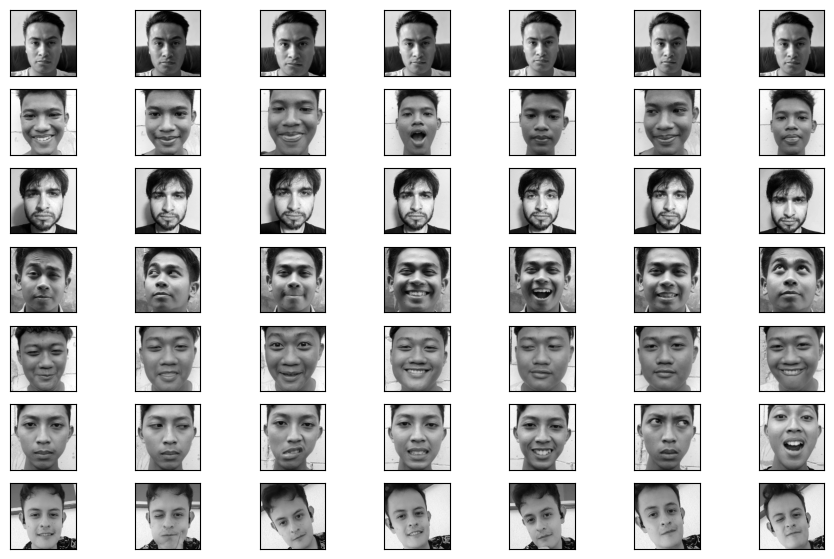

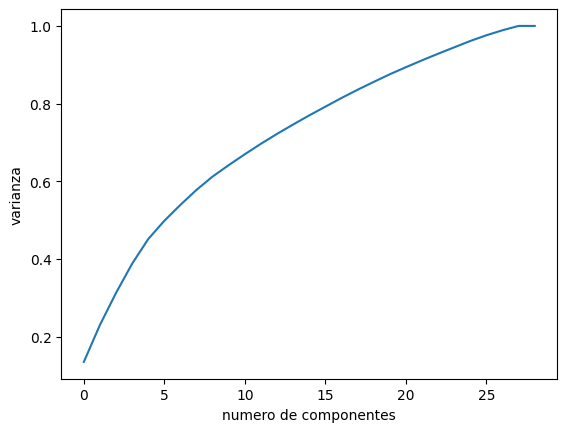

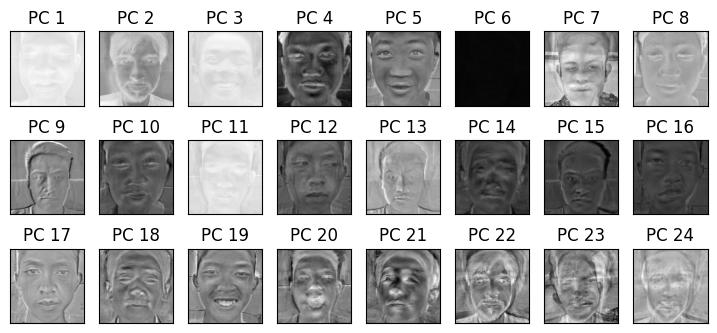

In [ ]:
originales(pixels)
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('numero de componentes')
plt.ylabel('varianza');
plt.show()
eigenfaces_algorith(eigenfaces.T)

## Reconstrucción

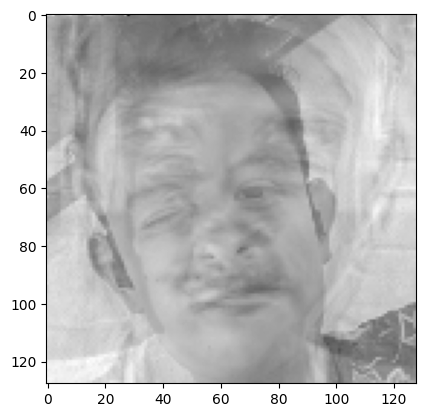

In [ ]:
img_reconstruida = reconstruir(media,eigenfaces,X_test[2])
img_reconstruida = img_reconstruida.reshape(128,128)

plt.imshow(img_reconstruida, cmap='gray')
plt.show()

## Clasificación

Termino en: 0.035s
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         4

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



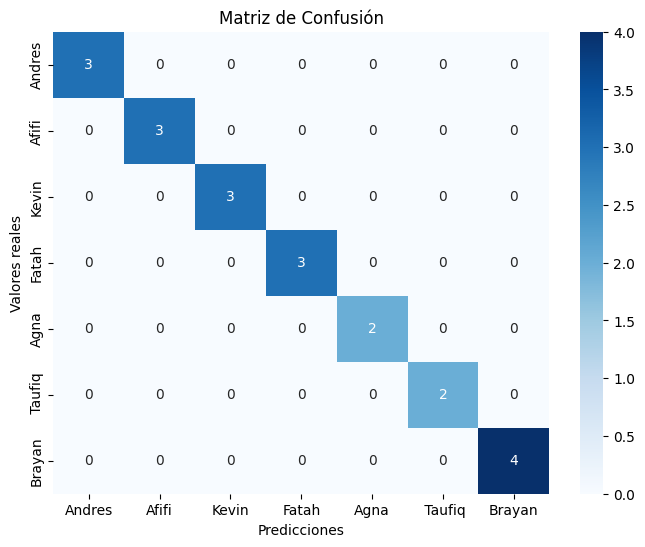

In [ ]:
from time import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Crear y entrenar el clasificador SVC
classifier = SVC(kernel='linear')
classifier.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
t0 = time()
y_pred = classifier.predict(X_test)

# Evaluar el rendimiento
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Termino en: %0.3fs" % (time() - t0))
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')



# Crear la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Andres","Afifi", "Kevin", "Fatah","Agna"," Taufiq","Brayan"],
            yticklabels=["Andres","Afifi", "Kevin", "Fatah","Agna"," Taufiq","Brayan"])
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.title("Matriz de Confusión")
plt.show()

Termino en: 0.005s
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.38      1.00      0.55         3
           2       0.67      0.67      0.67         3
           3       1.00      0.67      0.80         3
           4       0.00      0.00      0.00         2
           5       1.00      0.50      0.67         2
           6       0.80      1.00      0.89         4

    accuracy                           0.60        20
   macro avg       0.55      0.55      0.51        20
weighted avg       0.57      0.60      0.55        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


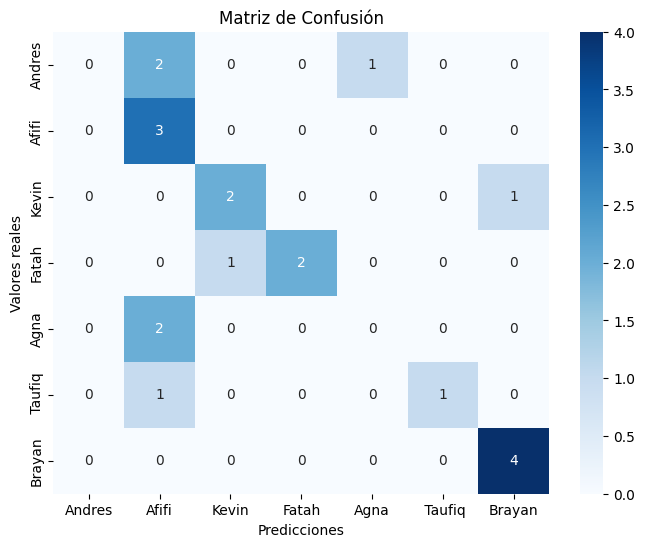

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
gnb = GaussianNB()
t0 = time()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Termino en: %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))

# Crear la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Andres","Afifi", "Kevin", "Fatah","Agna"," Taufiq","Brayan"],
            yticklabels=["Andres","Afifi", "Kevin", "Fatah","Agna"," Taufiq","Brayan"])
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.title("Matriz de Confusión")
plt.show()

## Algorítmo PCA scikit learn

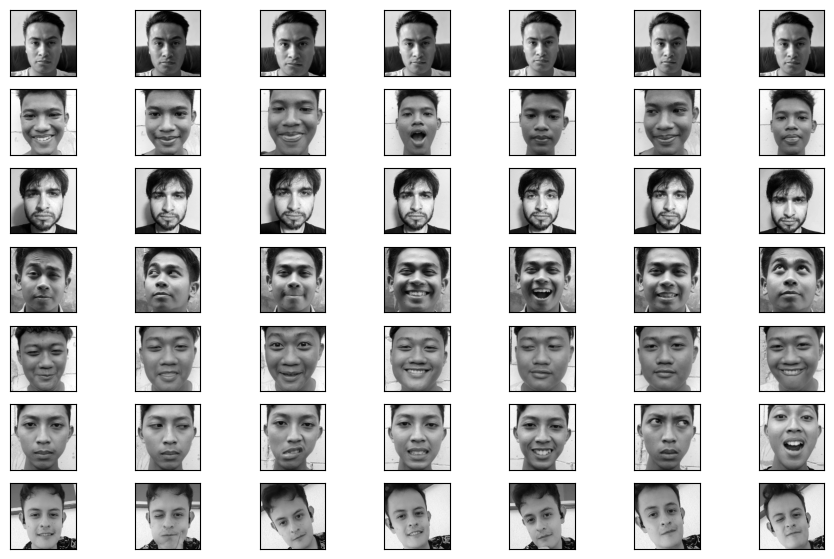

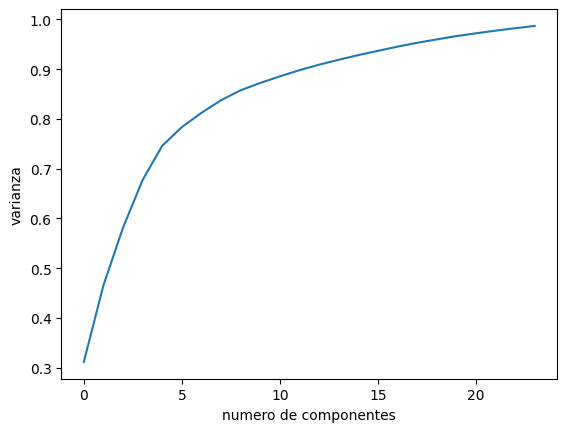

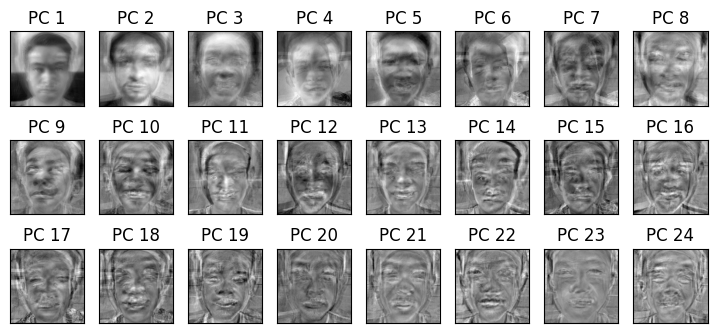

Proyección de la imagen en el nuevo espacio


In [ ]:
from time import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA




originales(pixels)


# PCA de scikit
pca = PCA(24).fit(x_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('numero de componentes')
plt.ylabel('varianza');
plt.show()

eigenfaces_pca(pca)

## Proyectando las imagenes de entrenamiento y prueba
print("Proyección de la imagen en el nuevo espacio")
Xtrain_pca = pca.transform(x_train)
Xtest_pca = pca.transform(x_test)
##############



Termino en: 0.014s
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         4

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



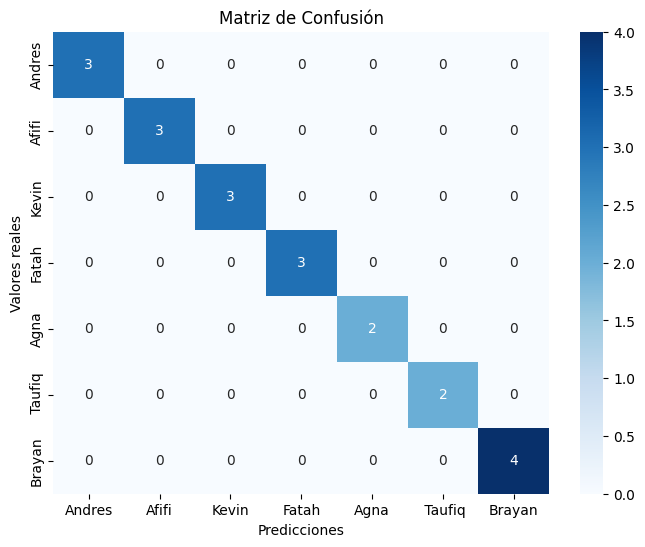

In [ ]:
from sklearn.svm import SVC

# Crear y entrenar el clasificador SVC
classifier = SVC(kernel='linear')
classifier.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
t0 = time()
y_pred = classifier.predict(X_test)

# Evaluar el rendimiento
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Termino en: %0.3fs" % (time() - t0))
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')


# Crear la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Andres","Afifi", "Kevin", "Fatah","Agna"," Taufiq","Brayan"],
            yticklabels=["Andres","Afifi", "Kevin", "Fatah","Agna"," Taufiq","Brayan"])
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.title("Matriz de Confusión")
plt.show()

Termino en: 5.434s
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.38      1.00      0.55         3
           2       0.67      0.67      0.67         3
           3       1.00      0.67      0.80         3
           4       0.00      0.00      0.00         2
           5       1.00      0.50      0.67         2
           6       0.80      1.00      0.89         4

    accuracy                           0.60        20
   macro avg       0.55      0.55      0.51        20
weighted avg       0.57      0.60      0.55        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


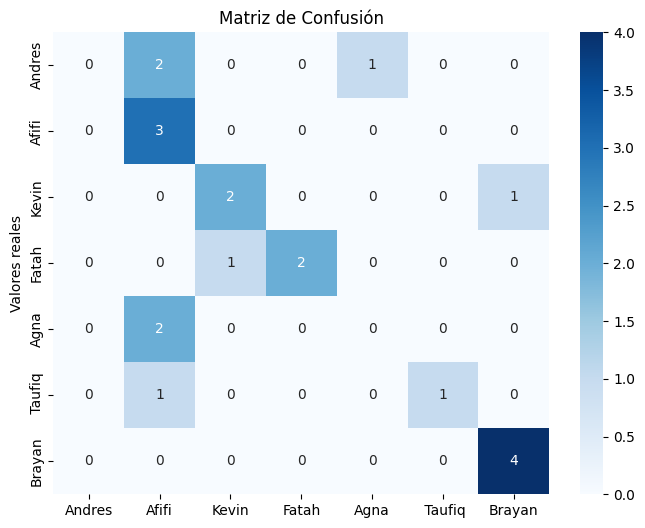

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Termino en: %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))

# Crear la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Andres","Afifi", "Kevin", "Fatah","Agna"," Taufiq","Brayan"],
            yticklabels=["Andres","Afifi", "Kevin", "Fatah","Agna"," Taufiq","Brayan"])
plt.ylabel("Valores reales")
plt.title("Matriz de Confusión")
plt.show()

# CONV-NET

## Conjunto de datos y normalización

In [ ]:
from tensorflow.keras.utils import to_categorical

tamaño_imagen = 128
# Convertir la columna 'Imagen' a un array de NumPy
df_cnn['Imagen'] = df_cnn['Imagen'].apply(np.array)

# Extraer características (imágenes) y etiquetas del DataFrame
imagenes = np.vstack(df_cnn['Imagen'].values)
etiquetas = df_cnn['Etiqueta'].values

# Dividir el conjunto de datos en entrenamiento y prueba
imagenes_entrenamiento, imagenes_prueba, etiquetas_entrenamiento, etiquetas_prueba = train_test_split(
    imagenes, etiquetas, test_size=0.4, random_state=42)

# Normalizar los valores de píxeles al rango [0, 1]
imagenes_entrenamiento = imagenes_entrenamiento / 255.0
imagenes_prueba = imagenes_prueba / 255.0

# Convertir etiquetas a one-hot encoding
etiquetas_entrenamiento_one_hot = to_categorical(etiquetas_entrenamiento)
etiquetas_prueba_one_hot = to_categorical(etiquetas_prueba)


## Arquitectura de red neuronal (capas)

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Dropout
from tensorflow import optimizers

tamaño_imagen = len(df_cnn['Imagen'].iloc[0])
print(tamaño_imagen)

modelo = Sequential()
modelo.add(Reshape((128, 128, 1), input_shape=(tamaño_imagen,)))
modelo.add(Conv2D(32, (3, 3), activation='relu'))
modelo.add(MaxPooling2D(2, 2))
modelo.add(Conv2D(64, (3, 3), activation='relu'))
modelo.add(MaxPooling2D(2, 2))
modelo.add(Conv2D(128, (3, 3), activation='relu'))
modelo.add(MaxPooling2D(2, 2))
modelo.add(Flatten())
modelo.add(Dense(128, activation='relu'))
modelo.add(Dropout(0.5))
modelo.add(Dense(7, activation='softmax'))


16384


In [ ]:
optimizer = optimizers.Adam(learning_rate = 0.001)
modelo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Entrenamiento

In [ ]:
# Entrenar el modelo
modelo.fit(imagenes_entrenamiento, etiquetas_entrenamiento, epochs=15)

Epoch 1/15
1/1 [==============================] - 3s 3s/step - loss: 1.9421 - accuracy: 0.0345
Epoch 2/15
1/1 [==============================] - 1s 1s/step - loss: 2.3084 - accuracy: 0.0690
Epoch 3/15
1/1 [==============================] - 1s 1s/step - loss: 1.8745 - accuracy: 0.1379
Epoch 4/15
1/1 [==============================] - 2s 2s/step - loss: 1.7913 - accuracy: 0.3793
Epoch 5/15
1/1 [==============================] - 2s 2s/step - loss: 1.8049 - accuracy: 0.2759
Epoch 6/15
1/1 [==============================] - 1s 1s/step - loss: 1.6927 - accuracy: 0.6897
Epoch 7/15
1/1 [==============================] - 1s 906ms/step - loss: 1.6353 - accuracy: 0.5862
Epoch 8/15
1/1 [==============================] - 1s 864ms/step - loss: 1.5112 - accuracy: 0.5862
Epoch 9/15
1/1 [==============================] - 1s 810ms/step - loss: 1.3038 - accuracy: 0.6897
Epoch 10/15
1/1 [==============================] - 1s 810ms/step - loss: 1.1370 - accuracy: 0.6552
Epoch 11/15
1/1 [====================

## Evaluación

In [ ]:
resultado = modelo.evaluate(imagenes_entrenamiento, etiquetas_entrenamiento)
print("Pérdida en el conjunto de prueba:", resultado[0])
print("Precisión en el conjunto de prueba:", resultado[1])

1/1 [==============================] - 0s 278ms/step - loss: 0.2542 - accuracy: 0.9655
Pérdida en el conjunto de prueba: 0.25424695014953613
Precisión en el conjunto de prueba: 0.9655172228813171


In [ ]:
modelo.save('Modelo')

ruta_modelo = 'Modelo'
modelo = tf.keras.models.load_model(ruta_modelo)

1/1 [==============================] - 0s 251ms/step


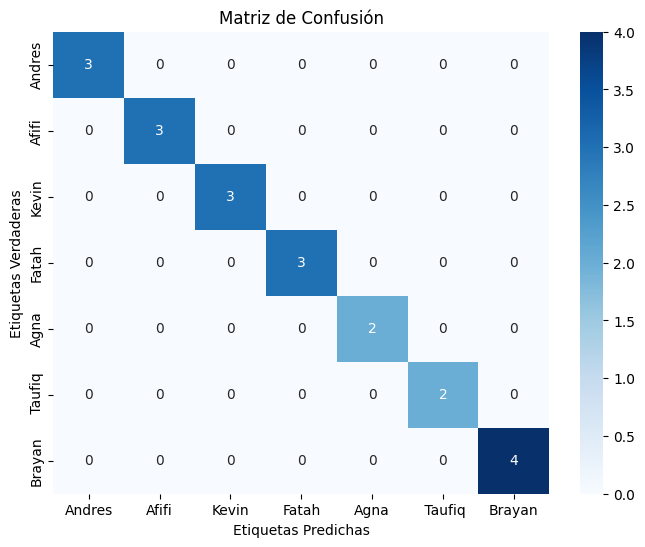

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         4

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [ ]:
predicciones = modelo.predict(imagenes_prueba)
etiquetas_predichas = np.argmax(predicciones, axis=1)

# Imprimir matriz de confusión
matriz_confusion = confusion_matrix(etiquetas_prueba, etiquetas_predichas)

# Imprimir la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='g', cmap='Blues',
             xticklabels=["Andres","Afifi", "Kevin", "Fatah","Agna"," Taufiq","Brayan"],
            yticklabels=["Andres","Afifi", "Kevin", "Fatah","Agna"," Taufiq","Brayan"])
plt.title('Matriz de Confusión')
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')
plt.show()

# Imprimir el reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(etiquetas_prueba, etiquetas_predichas))

## Prueba de clasificación

1/1 [==============================] - 0s 128ms/step


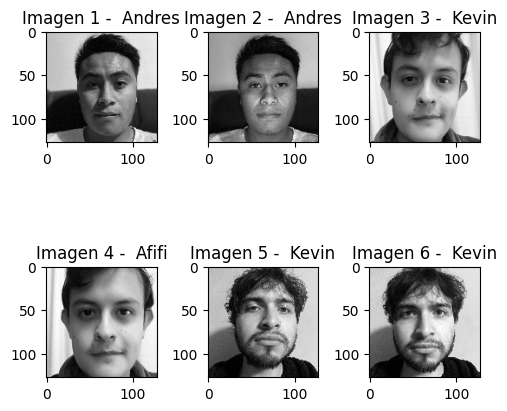

In [ ]:
# Cargar tu modelo de TensorFlow
# Reemplaza 'ruta/a/tu/modelo' con la ruta real de tu modelo

# Ruta de la carpeta que contiene las imágenes
carpeta_imagenes = "Predicciones"

# Lista para almacenar imágenes originales
imagenes_originales = []

# Lista para almacenar imágenes aplanadas
imagenes_aplanadas = []

# Recorrer cada archivo en la carpeta
for filename in os.listdir(carpeta_imagenes):
    ruta_completa = os.path.join(carpeta_imagenes, filename)

    # Leer la imagen con OpenCV
    imagen = cv.imread(ruta_completa, cv.IMREAD_GRAYSCALE)

    # Reducir tamaño a 128x128
    imagen_reducida = cv.resize(imagen, (128, 128))

    # Aplanar la imagen a una dimensión
    imagen_aplanada = imagen_reducida.flatten()

    # Agregar imágenes a las listas
    imagenes_originales.append(imagen_reducida)
    imagenes_aplanadas.append(imagen_aplanada)

# Convertir la lista de imágenes aplanadas a un array de NumPy
imagenes_aplanadas = np.array(imagenes_aplanadas)

# Normalizar las imágenes a valores entre 0 y 1
imagenes_aplanadas = imagenes_aplanadas / 255.0

# Realizar predicciones para cada imagen aplanada
predicciones = modelo.predict(imagenes_aplanadas)

# Obtener las etiquetas predichas (suponiendo que son clases enteras)
etiquetas_predichas = np.argmax(predicciones, axis=1)

# Mostrar imágenes originales con etiquetas predichas usando Matplotlib
# Configurar la disposición de los subplots
filas = len(imagenes_originales) // 3 + (len(imagenes_originales) % 3 > 0)
fig, axs = plt.subplots(filas, 3, figsize=(5, 5))

mapeo_clases = {
    0: "Andres", 1: "Afifi",2: "Kevin",
    3: "Fatah", 4: "Agna",5: "Taufiq",
    6: "Brayan", }


# Mostrar imágenes originales con etiquetas predichas usando Matplotlib
for i, (imagen, prediccion) in enumerate(zip(imagenes_originales, etiquetas_predichas)):
    fila_actual = i // 3
    columna_actual = i % 3

    axs[fila_actual, columna_actual].imshow(imagen, cmap='gray')  # Mostrar en escala de grises
    axs[fila_actual, columna_actual].set_title(f'Imagen {i+1} -  {mapeo_clases.get(prediccion, "Clase Desconocida")}')

# Ajustar el espacio entre subplots
plt.tight_layout()
plt.show()